# spectral gap再実験の解析

## import

In [48]:
import numpy as np
import scipy.linalg
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colorbar as colorbars
import matplotlib.gridspec as gridspec
import datetime
import os
import time
import pathlib
import pickle
import sys
import random
import uncertainties
from uncertainties import ufloat
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import ising_model as ising
import made
import QAOA_function as qaoa
import mcmc_function as mcmc

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['mathtext.fontset'] = 'cm'

seed = 1454
rng = np.random.default_rng(seed)
random.seed(seed)
generator = torch.Generator()
generator.manual_seed(seed)
torch.manual_seed(seed)

## データのロード

In [49]:
n_spin_min = 3
n_spin_max = 12
beta_list = [1e-1, 1e0, 2e0, 5e0, 1e1]

n_spin_list = np.arange(n_spin_min, n_spin_max+1)

# データ取得
i = 0
for beta in beta_list:
	j = 0
	for n_spin in n_spin_list:
		if j == 0:
			gap_data_beta = np.load("result/spectral_gap/{0}_sites/beta_{1}.npy".format(n_spin, '{:.0e}'.format(beta_list[i])))[np.newaxis]
			gap_add_data_beta = np.load("result/spectral_gap/{0}_sites/beta_{1}_add_data.npy".format(n_spin, '{:.0e}'.format(beta_list[i])))[np.newaxis]
		else:
			gap_data_beta = np.concatenate([gap_data_beta, np.load("result/spectral_gap/{0}_sites/beta_{1}.npy".format(n_spin, '{:.0e}'.format(beta_list[i])))[np.newaxis]])
			gap_add_data_beta = np.concatenate([gap_add_data_beta, np.load("result/spectral_gap/{0}_sites/beta_{1}_add_data.npy".format(n_spin, '{:.0e}'.format(beta_list[i])))[np.newaxis]])
		j += 1

	if i == 0:
		gap_data = gap_data_beta[np.newaxis]
		gap_add_data = gap_add_data_beta[np.newaxis]
	else:
		gap_data = np.concatenate([gap_data, gap_data_beta[np.newaxis]])
		gap_add_data = np.concatenate([gap_add_data, gap_add_data_beta[np.newaxis]])
 
	i += 1
 
# 形状確認
print(gap_data.shape)
print(gap_add_data.shape)
# axis0: beta, axis1: n_spin, axis2: proposal, axis3: instance

(5, 10, 5, 100)
(5, 10, 2, 100)


## n=3のデータの解析

[1.24319769e-04 9.78257385e-01 2.15268420e-02 6.01258091e-03
 9.40486968e-01 3.37954744e-01 1.34714099e-02 9.70858277e-01
 1.21833159e-02 1.52142481e-05 9.85996752e-01 3.68921228e-04
 4.51422757e-02 8.61561248e-06 4.40436803e-02 1.35526418e-03
 1.43235813e-05 9.76349962e-01 9.29152569e-01 9.44498273e-01
 9.73993381e-01 6.06122476e-03 9.25484362e-01 5.07036613e-02
 9.61319614e-01 4.97215888e-01 9.50647268e-01 2.65050188e-03
 4.04881860e-03 5.22294687e-04 3.46992444e-01 5.42207568e-04
 8.99861097e-01 2.56461966e-03 9.43287955e-05 4.78346513e-02
 4.94340907e-01 3.40350610e-03 2.48032850e-03 4.23752551e-03
 7.64194216e-01 9.38242871e-01 1.91962760e-03 9.40283984e-01
 9.82418444e-01 2.70396114e-03 8.19127134e-01 9.81127418e-01
 9.59864557e-01 1.08134009e-03 5.43601600e-05 9.81380266e-01
 9.80964167e-01 4.45857017e-05 9.93763353e-01 9.73179764e-01
 2.43168259e-01 4.73779798e-02 2.28749248e-03 1.17427189e-01
 5.84447364e-02 1.20349876e-04 1.77559817e-05 9.62394114e-01
 8.57215781e-01 5.657354

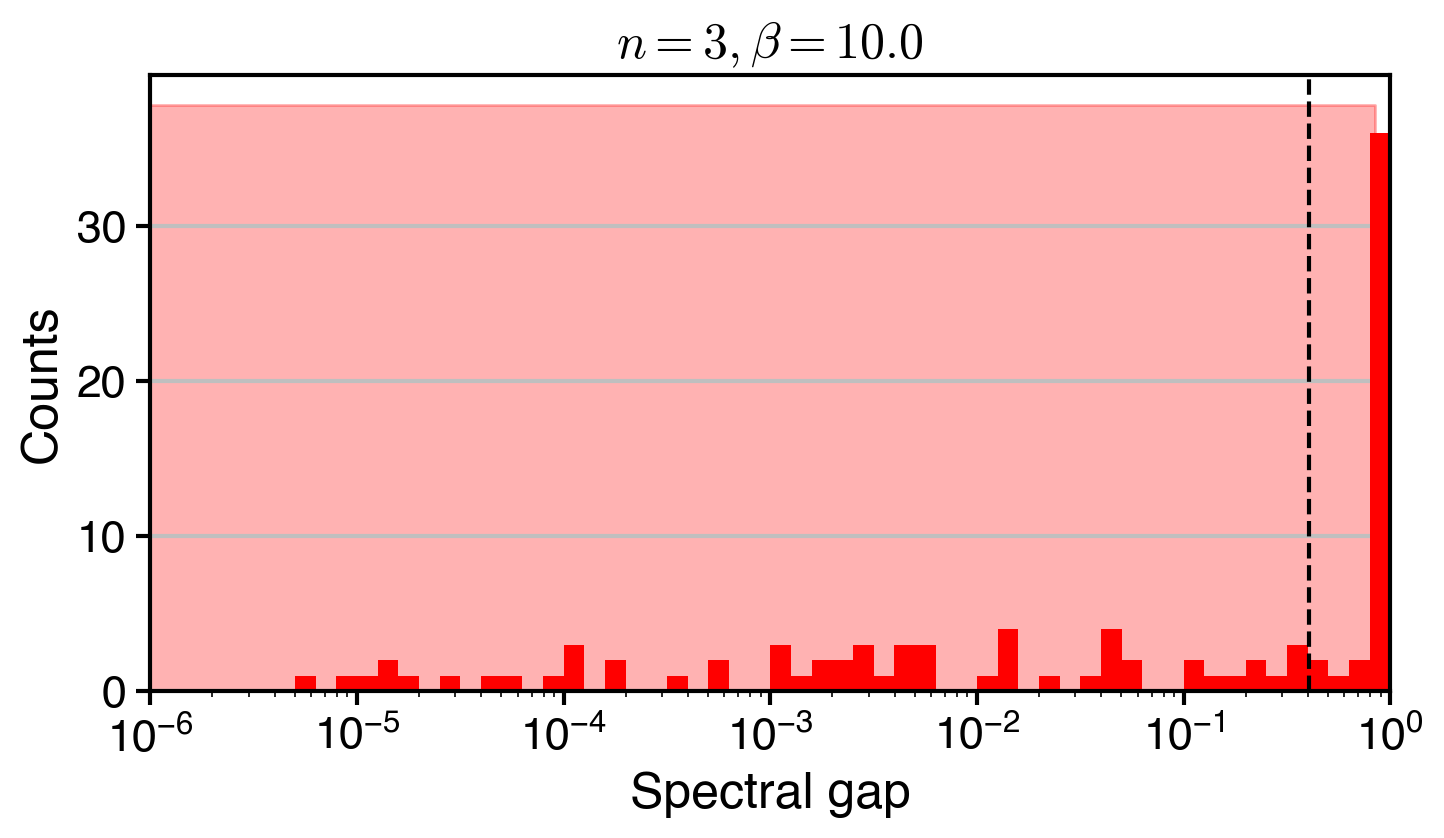

In [50]:
# when beta = 10.0
n_spin = 3
beta = beta_list[4]
opt_gap_data = gap_add_data[4,0,0]
print(opt_gap_data)
print(opt_gap_data.shape)

# plot the histogram of spectral gaps when beta=10.0 and n=3
bins = np.logspace(-6, 0, num=61)
hist = np.histogram(opt_gap_data, bins=bins)

fig1, ax1 = plt.subplots(figsize=(8,4), dpi=200)

spines = 1.5
ax1.spines["top"].set_linewidth(spines)
ax1.spines["left"].set_linewidth(spines)
ax1.spines["bottom"].set_linewidth(spines)
ax1.spines["right"].set_linewidth(spines)

ax1.hist(opt_gap_data, bins=hist[1], color='red', label='MADE+QAOA(opt)', zorder=2)
ax1.fill_betweenx(y=ax1.get_ylim(), x1=np.average(opt_gap_data)-np.std(opt_gap_data), x2=np.average(opt_gap_data)+np.std(opt_gap_data), color='red', alpha=0.3)
ax1.axvline(x=np.average(opt_gap_data), color='black', linestyle='--')
ax1.grid(axis='y', color='#BFBFBF', linestyle='-', linewidth=1.5, zorder=1)
ax1.set_xscale('log')
ax1.set_xlim(1e-6, 1e0)
ax1.set_xlabel('Spectral gap', fontsize=18)
ax1.set_ylabel('Counts', fontsize=18)
ax1.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax1.set_title(r'$n={0}, \beta={1}$'.format(n_spin, beta), fontsize=18)

print(np.average(opt_gap_data))
print(np.std(opt_gap_data))
print(opt_gap_data.min())

## 特に悪いインスタンスに対する解析

5.65735435031911e-06
0.1505530116842474
0.608705629743115
[4.9787760e-01 4.2358153e-03 5.3835396e-05 9.1548980e-05 3.1062969e-04
 1.5657219e-04 4.8325351e-03 4.9244148e-01]


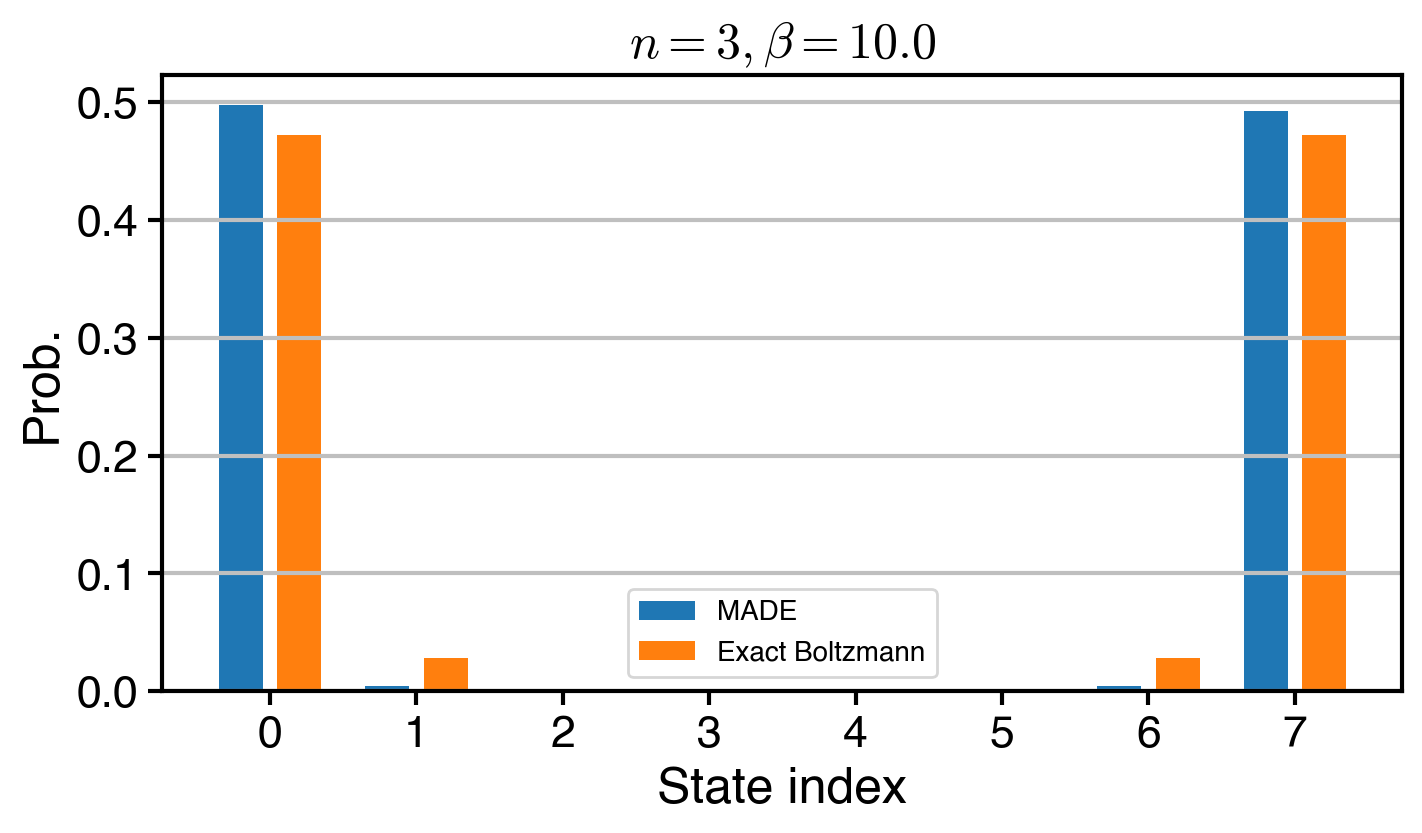

In [72]:
torch.use_deterministic_algorithms(True)

# import instance sets
n_spin = 3
source_dir_name = 'data/instance_set_2024-0614-1705-31'
fname_in = pathlib.Path(source_dir_name).joinpath('{0}_sites_instance_set.pickle'.format(n_spin))
with open(str(fname_in), 'rb') as f:
	instance_set = pickle.load(f)

min_idx = opt_gap_data.argmin()
print(opt_gap_data[min_idx])
instance = instance_set[min_idx]

# model train
# QAOA
n_layers = 5
qaoa_init_para = [0.2705, -0.5899, 0.4803, -0.4492, 0.5074, -0.3559, 0.5646, -0.2643, 0.6397, -0.1291] #文献におけるSKmodelに対するQAOA(p=5)の固定角
#qaoa_init_para = [0.2528, 0.6004, 0.4531, 0.4670, 0.4750, 0.3880, 0.5146, 0.3176, 0.5650, 0.2325, 0.6392, 0.1291] #文献におけるSKmodelに対するQAOA(p=6)の固定角
qaoa_method = "BFGS"
qaoa_options = {"disp": False, "maxiter": 200, "gtol": 1e-6}

# MADE
n_train = 1000
n_test = int(n_spin * 0.25)
hidden_size = int(2 * n_spin)
hidden_layers = 2
batchsize = 8
lr = 0.005
n_epochs = 30

# optimize QAOA ansatz
prob_hamiltonian = instance.get_hamiltonian()
mixer_hamiltonian = qaoa.generate_X_mixer(n_spin)
qaoa_ansatz = qaoa.QAOA_ansatz(prob_hamiltonian, mixer_hamiltonian, n_layers)
def qaoa_cost(para):
	return qaoa.cost_QAOA(prob_hamiltonian, qaoa_ansatz, para)
if qaoa_init_para == None:
	qaoa_para = [rng.uniform(0, 2*np.pi) for i in range(2*n_layers)]
else:
	qaoa_para = qaoa_init_para
qaoa_opt = scipy.optimize.minimize(qaoa_cost, qaoa_para, method=qaoa_method, options=qaoa_options)

# sampling from QAOA distribution
qaoa_opt_data_idx = qaoa.sampling_QAOA(qaoa_ansatz, qaoa_opt.x, n_train+n_test, seed) # optimize parameter
qaoa_fix_data_idx = qaoa.sampling_QAOA(qaoa_ansatz, qaoa_init_para, n_train+n_test, seed) # fixed angle
qaoa_opt_data_nd = np.array([qaoa.number_to_binary(qaoa_opt_data_idx[i], n_spin) for i in range(len(qaoa_opt_data_idx))], dtype='float32') # MADEモデルのコードが重み行列をfloat32で記述しているため、データもfloat32に明示的に指定する！
qaoa_fix_data_nd = np.array([qaoa.number_to_binary(qaoa_fix_data_idx[i], n_spin) for i in range(len(qaoa_fix_data_idx))], dtype='float32')
generator.manual_seed(seed)
qaoa_opt_data = torch.from_numpy(qaoa_opt_data_nd).to(dtype=torch.float32)
qaoa_opt_traindata, qaoa_opt_testdata = torch.utils.data.random_split(dataset=qaoa_opt_data, lengths=[n_train, n_test], generator=generator)
qaoa_fix_data = torch.from_numpy(qaoa_fix_data_nd).to(dtype=torch.float32)
qaoa_fix_traindata, qaoa_fix_testdata = torch.utils.data.random_split(dataset=qaoa_fix_data, lengths=[n_train, n_test], generator=generator)
qaoa_opt_testset = torch.utils.data.DataLoader(qaoa_opt_testdata, batch_size=batchsize, shuffle=False)
qaoa_opt_trainset = torch.utils.data.DataLoader(qaoa_opt_traindata, batch_size=batchsize, shuffle=False)
qaoa_fix_testset = torch.utils.data.DataLoader(qaoa_fix_testdata, batch_size=batchsize, shuffle=False)
qaoa_fix_trainset = torch.utils.data.DataLoader(qaoa_fix_traindata, batch_size=batchsize, shuffle=False)

# learn MADE by QAOA samples
hidden_list = [hidden_size for i in range(hidden_layers)]
model_qaoa_opt = made.MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True, seed=seed)
model_qaoa_fix = made.MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True, seed=seed)
opt_qaoa_opt = torch.optim.Adam(model_qaoa_opt.parameters(), lr=lr, weight_decay=1e-4)
scheduler_qaoa_opt = torch.optim.lr_scheduler.StepLR(opt_qaoa_opt, step_size=45, gamma=0.1)
opt_qaoa_fix = torch.optim.Adam(model_qaoa_fix.parameters(), lr=lr, weight_decay=1e-4)
scheduler_qaoa_fix = torch.optim.lr_scheduler.StepLR(opt_qaoa_fix, step_size=45, gamma=0.1)
made.run_train(model_qaoa_opt, qaoa_opt_trainset, qaoa_opt_testset, n_epochs, opt_qaoa_opt, scheduler_qaoa_opt, seed)
made.run_train(model_qaoa_fix, qaoa_fix_trainset, qaoa_fix_testset, n_epochs, opt_qaoa_fix ,scheduler_qaoa_fix, seed)

# get QAOA-MADE proposal
all_inputs = np.array([made.number_to_binary(i, n_spin) for i in range(2**n_spin)])
qaoa_opt_pred_dist = made.compute_log_prob(model_qaoa_opt, all_inputs)
qaoa_opt_pred_dist = np.exp(qaoa_opt_pred_dist)
qaoa_fix_pred_dist = made.compute_log_prob(model_qaoa_fix, all_inputs)
qaoa_fix_pred_dist = np.exp(qaoa_fix_pred_dist)

# get proposal matrix
qaoa_opt_made_Q = np.zeros((2**n_spin, 2**n_spin))
qaoa_fix_made_Q = np.zeros((2**n_spin, 2**n_spin))
for i in range(2**n_spin):
	for j in range(2**n_spin):
		qaoa_opt_made_Q[j,i] = qaoa_opt_pred_dist[j] # MADE(QAOA + opt)
		qaoa_fix_made_Q[j,i] = qaoa_fix_pred_dist[j] # MADE(QAOA + fixed angle)
		
# calculate spectral gap
energy = np.array([ising.spin_energy(ising.number_to_spin(i, n_spin), instance) for i in range(2**n_spin)])
# MADE(QAOA)
qaoa_opt_made_P = np.zeros((2**n_spin, 2**n_spin))
qaoa_fix_made_P = np.zeros((2**n_spin, 2**n_spin))

qaoa_opt_made_A = mcmc.calc_boltzmann_mh_acceptance(energy, qaoa_opt_made_Q, beta)

qaoa_fix_made_A = mcmc.calc_boltzmann_mh_acceptance(energy, qaoa_fix_made_Q, beta)
qaoa_opt_made_P = qaoa_opt_made_Q * qaoa_opt_made_A
qaoa_fix_made_P = qaoa_fix_made_Q * qaoa_fix_made_A

np.fill_diagonal(qaoa_opt_made_P, 0)
np.fill_diagonal(qaoa_fix_made_P, 0)

for i in range(2**n_spin):
	qaoa_opt_made_P[i,i] = 1 - np.sum(qaoa_opt_made_P[:,i])
	qaoa_fix_made_P[i,i] = 1 - np.sum(qaoa_fix_made_P[:,i])

# exact boltzmann prob
boltzmann_prob = ising.spin_boltzmann_distribution(instance, beta=beta_list[4])

# plot
fig2, ax2 = plt.subplots(figsize=(8,4), dpi=200)

spines = 1.5
ax2.spines["top"].set_linewidth(spines)
ax2.spines["left"].set_linewidth(spines)
ax2.spines["bottom"].set_linewidth(spines)
ax2.spines["right"].set_linewidth(spines)

ax2.bar(np.arange(2**n_spin)-0.2, qaoa_opt_pred_dist, width=0.3, label='MADE')
ax2.bar(np.arange(2**n_spin)+0.2, boltzmann_prob, width=0.3, label='Exact Boltzmann')
ax2.grid(axis='y', color='#BFBFBF', linestyle='-', linewidth=1.5, zorder=1)
ax2.set_xlabel('State index', fontsize=18)
ax2.set_ylabel('Prob.', fontsize=18)
ax2.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax2.set_title(r'$n={0}, \beta={1}$'.format(n_spin, beta), fontsize=18)
ax2.legend()

print(mcmc.spectral_gap(qaoa_opt_made_P))
print(mcmc.spectral_gap(qaoa_fix_made_P))
print(qaoa_opt_pred_dist)